In [6]:
# Run command to install required packages
!pip install -r requirements.txt

  Using cached datasets-3.6.0-py3-none-any.whl.metadata (19 kB)
  Using cached dill-0.3.8-py3-none-any.whl.metadata (10 kB)
  Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl.metadata (5.9 kB)
  Using cached aiosignal-1.3.2-py2.py3-none-any.whl.metadata (3.8 kB)
  Using cached attrs-25.3.0-py3-none-any.whl.metadata (10 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.9/73.9 kB 1.1 MB/s eta 0:00:00a 0:00:01
Using cached datasets-3.6.0-py3-none-any.whl (491 kB)
Using cached dill-0.3.8-py3-none-any.whl (116 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 146.7/146.7 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 MB 34.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 56.9 MB/s eta 0:00:00
Using cached aiohappyeyeballs-2.6.1-py3-none-any.whl (15 kB)
Using cac

In [39]:
# Imports all the needed dependencies for the project.
import os 
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import json
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, TrainingArguments
from dotenv import load_dotenv
import os
import accelerate
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training, PeftModel
from trl import SFTTrainer
from datasets import Dataset

In [10]:
# Load the dataset
rawDataPath = "synthetic_defects_5k.csv"
assert os.path.exists(rawDataPath), f"{rawDataPath} not found."

rawDF = pd.read_csv(rawDataPath)
rawDF = (
    rawDF
    .drop_duplicates()
    .dropna()
    .reset_index(drop=True)
)

In [11]:
# Combine text columns into a single column for analysis
rawDF["combined"] = (
    rawDF["Description"] + " " +
    rawDF["Root Cause"] + " " +
    rawDF["Path to Fix"]
)


In [ ]:
# Create a TF-IDF vectorizer to convert text data into numerical format
vectorizer = TfidfVectorizer(
    max_features=1000,           
    stop_words="english",        
)
X_tfidf = vectorizer.fit_transform(rawDF["combined"])


In [13]:
# Print the shape of the TF-IDF matrix
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_tfidf.toarray())

# Variance diagnostics (optional print)
expl_var = pca.explained_variance_ratio_
print(f"Explained variance ratio: {expl_var[0]:.3f}, {expl_var[1]:.3f}")

Explained variance ratio: 0.064, 0.061


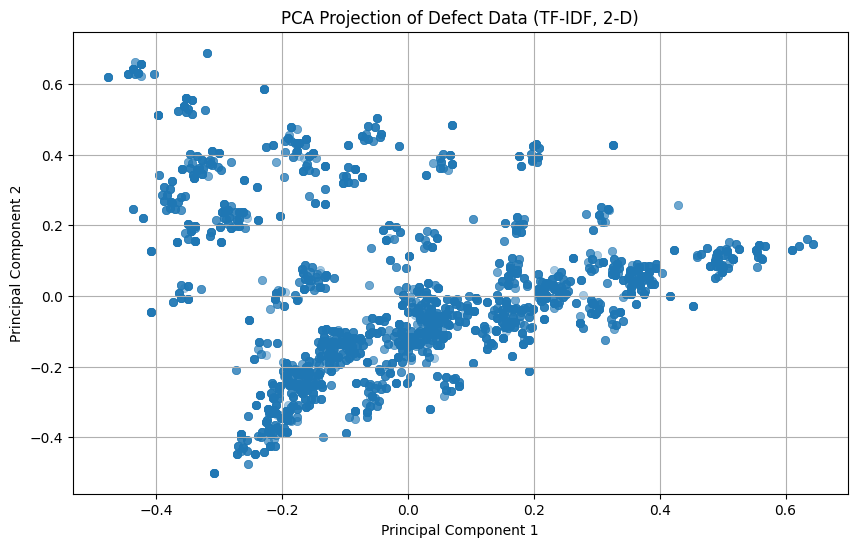

Plot saved to: pca_defects_projection.png


In [14]:
# Plot the PCA projection
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    alpha=0.4,
    edgecolor=None
)
plt.title("PCA Projection of Defect Data (TF-IDF, 2-D)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)

plot_path = "pca_defects_projection.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Plot saved to: {plot_path}")

In [ ]:
# Save the PCA results back to the original DataFrame
rawDF["PC1"] = X_pca[:, 0]
rawDF["PC2"] = X_pca[:, 1]
rawDF.to_csv("defects_with_pca.csv", index=False)

# Numpy matrix if needed elsewhere
import numpy as np
np.save("X_pca.npy", X_pca)

print("Finished: cleaned data, PCA matrix, and plot saved.")

Finished: cleaned data, PCA matrix, and plot saved.


In [16]:
# Load the PCA results for further analysis
df = pd.read_csv("defects_with_pca.csv")

#  Create a list of dictionaries with instruction/output format
converted = []

for _, row in df.iterrows():
    instruction = (
        "Given a defect report and its root cause, suggest a fix path.\n\n"
        f"Defect: {row['Description']}\n"
        f"Root cause: {row['Root Cause']}"
    )
    output = row["Path to Fix"]
    converted.append({"instruction": instruction, "response": output})
    
# Save the converted data to a JSON file
with open("defects_instructions.json", "w") as f:
    json.dump(converted, f, indent=2)
print("Converted data saved to defects_instructions.json")

Converted data saved to defects_instructions.json


In [ ]:
# Script to convert a base model to 4-bit quantization using bitsandbytes
load_dotenv()

HF_TOKEN = os.getenv("HF_TOKEN")

script_dir = os.getcwd()
base_model_path = os.path.join(script_dir, "models", "base")
fourbit_model_path = os.path.join(script_dir, "models", "4bit")
os.makedirs(fourbit_model_path, exist_ok=True)
os.makedirs(base_model_path, exist_ok=True)


modelName = "google/gemma-3-1b-it"
tokenizer = AutoTokenizer.from_pretrained(modelName, use_fast=True)
baseModel = AutoModelForCausalLM.from_pretrained(modelName, cache_dir=base_model_path, trust_remote_code=True)
baseModel.save_pretrained(base_model_path)
tokenizer.save_pretrained(base_model_path)

bnb_config_4bit = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_use_double_quant = True,
    bnb_4bit_compute_dtype = torch.bfloat16,
)

model_4bit = AutoModelForCausalLM.from_pretrained(
    modelName,
    quantization_config=bnb_config_4bit,
    cache_dir=fourbit_model_path,
    trust_remote_code=True,
    device_map = "auto"
)
model_4bit.save_pretrained(fourbit_model_path)
# Save quantized model
model_4bit.save_pretrained(fourbit_model_path)
tokenizer.save_pretrained(fourbit_model_path)









('/home/mogi/qlora-finetune-project/models/4bit/tokenizer_config.json',
 '/home/mogi/qlora-finetune-project/models/4bit/special_tokens_map.json',
 '/home/mogi/qlora-finetune-project/models/4bit/chat_template.jinja',
 '/home/mogi/qlora-finetune-project/models/4bit/tokenizer.json')

In [ ]:

model_path = "models/4bit"  # Make sure this is correct

# changes how aggressive the inlufence of lora is on the base model. 

lora_config = LoraConfig(
    r=4,
    lora_alpha=8,
    lora_dropout=0.1,
    target_modules=["q_proj", "o_proj", "k_proj", "v_proj", "gate_proj", "up_proj", "down_proj"],
    task_type="CAUSAL_LM"
)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_use_double_quant=True,
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=True)

model = prepare_model_for_kbit_training(model)
model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

trainable params: 3,261,440 || all params: 1,003,147,392 || trainable%: 0.3251


In [ ]:
# Load your JSON file (local dataset with instruction-response pairs)
with open("defects_instructions.json", "r") as f:
    raw_data = json.load(f)

# Format each example into a single text field
def format_example(example):
    return {
        "text": f"""### Instruction:
{example['instruction']}

### Response:
{example['response']}"""
    }

# Apply formatting to every item in the list
formatted_data = [format_example(entry) for entry in raw_data]

# Convert the list into a Hugging Face Dataset object
dataset = Dataset.from_list(formatted_data)


In [ ]:
# Define a tokenization function that takes in a single example

def tokenize(example):
    return tokenizer(
        example["text"],             
        padding="max_length",        
        truncation=True,             
        max_length=512              
    )

# Apply the tokenization function to the full dataset
tokenized_dataset = dataset.map(tokenize, batched=True)


Map: 100%|██████████| 5000/5000 [00:00<00:00, 9058.98 examples/s] 


In [ ]:
# Define all your training hyperparameters here
training_args = TrainingArguments(
    output_dir="./lora-defects-output",    
    per_device_train_batch_size=1,         
    gradient_accumulation_steps=4,        
    num_train_epochs=5,                    
    logging_steps=10,                      
    save_strategy="epoch",                               
    fp16=True,                            
    report_to="none",                     
    learning_rate = 2e-4  

)

# Create the SFTTrainer:  this wraps the model, tokenizer, and data into one trainer
trainer = SFTTrainer(
    model=model,                          
    #tokenizer=tokenizer,                  
    train_dataset=tokenized_dataset,      
    #dataset_text_field="text",            
    args=training_args                  
)


trainer.train()


Truncating train dataset: 100%|██████████| 5000/5000 [00:00<00:00, 430052.70 examples/s]
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
/home/mogi/qlora-finetune-project/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)


Step,Training Loss
10,9.440000
20,1.583500
30,0.263600
40,0.132000
50,0.080300
60,0.045800
70,0.034400
80,0.032400
90,0.031800
100,0.032600


/home/mogi/qlora-finetune-project/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/home/mogi/qlora-finetune-project/venv/lib/python3.12/site-packages/torch/_dynamo/eval_frame.py:838: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs

TrainOutput(global_step=6250, training_loss=0.04111673699378967, metrics={'train_runtime': 9585.7931, 'train_samples_per_second': 2.608, 'train_steps_per_second': 0.652, 'total_flos': 5.38488963072e+16, 'train_loss': 0.04111673699378967})

In [42]:
# Merges the adapters from the fine tune into the base model

model = AutoModelForCausalLM.from_pretrained(
    "models/4bit",
    device_map = "auto",
    trust_remote_code= True 
)

model = PeftModel.from_pretrained(model, "lora-defects-output/checkpoint-6250" )
model = model.merge_and_unload()
model.save_pretrained("google-gemma3-1b-QLoRA")
tokenizer = AutoTokenizer.from_pretrained("models/4bit", use_fast=True)
tokenizer.save_pretrained("google-gemma3-1b-QLoRA")

fmt = lambda b: f"{b / 1024**2:.2f} MB" if b < 1024**3 else f"{b / 1024**3:.2f} GB"
size = lambda path: sum(os.path.getsize(os.path.join(dp, f)) for dp, _, fs in os.walk(path) for f in fs)

print("Pre-QLoRA:", fmt(size("models/4bit")), "| Post-QLoRA:", fmt(size("google-gemma3-1b-QLoRA")))





Pre-QLoRA: 4.66 GB | Post-QLoRA: 952.84 MB
